# PreTrain

In [1]:
from model.sswae_dev2_2 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 8
rm = [4,9]

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10 - len(rm) + 1),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [3]:
labeled_class = [i for i in range(10) if i not in rm]
print("lab:", labeled_class, "rm:", rm)
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, rm], portion = 1.0, unk=True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

lab: [0, 1, 2, 3, 5, 6, 7, 8] rm: [4, 9]


In [4]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [5]:
epoch = 20
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.199
[2] loss: 0.136
[3] loss: 0.043
[4] loss: 0.025
[5] loss: 0.015
[6] loss: 0.011
[7] loss: 0.010
[8] loss: 0.007
[9] loss: 0.006
[10] loss: 0.007
[11] loss: 0.006
[12] loss: 0.004
[13] loss: 0.003
[14] loss: 0.004
[15] loss: 0.005
[16] loss: 0.004
[17] loss: 0.003
[18] loss: 0.003
[19] loss: 0.002
[20] loss: 0.004


In [6]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 8])

In [7]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

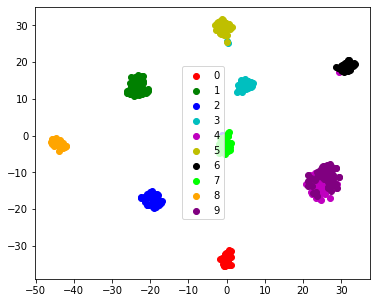

In [8]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

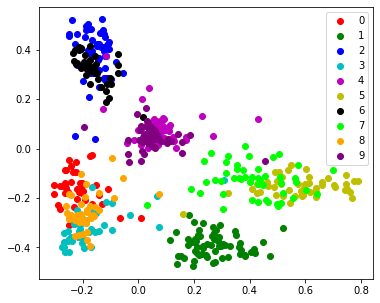

In [9]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [10]:
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, rm], portion = 1.0, class_no = True, unk=True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [11]:
ys = np.zeros((10 - len(rm) + 1, y_dim))
cs = np.zeros(10 - len(rm) + 1)
covs = np.zeros((10 - len(rm) + 1, y_dim, y_dim))

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10 - len(rm) + 1, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()
    
    for i in range(10 - len(rm)):
        cov = torch.cov(z[y==i,:].T, correction=0) * torch.sum(y==i)
        covs[i,:,:] += cov.detach().to('cpu').numpy()

In [12]:
w1 = torch.Tensor(ys.transpose()/cs)
w1

tensor([[-2.0888e-01,  2.8335e-01, -1.4292e-01, -1.8666e-01,  5.9319e-01,
         -1.4520e-01,  4.6424e-01, -1.7162e-01,  9.1099e-02],
        [ 5.8438e-01, -3.5987e-01, -1.6496e-01, -2.3221e-01, -2.4828e-01,
         -2.7627e-01,  3.4321e-04, -3.1486e-01,  2.5345e-01],
        [-1.4579e-01, -3.8353e-01,  3.7855e-01, -3.2674e-01, -1.4405e-01,
          3.0385e-01, -1.2275e-01, -2.7032e-01,  6.2857e-02],
        [-2.5847e-01,  3.3544e-01,  2.6239e-01,  4.9399e-01, -2.3526e-01,
         -2.5164e-01,  2.5319e-01, -2.3726e-01, -2.5585e-01],
        [-2.7008e-01,  2.7069e-01, -2.7721e-01, -7.1031e-02,  5.4667e-02,
          4.2802e-01, -2.6985e-01, -2.4608e-01,  1.3648e-01],
        [-1.6550e-01,  3.9282e-01,  8.5370e-02, -2.5187e-01, -1.5523e-01,
         -2.1571e-01, -2.3898e-01,  4.1629e-01,  3.3405e-01],
        [ 3.2492e-01, -2.4192e-01, -2.3327e-01,  3.0928e-01,  3.5598e-01,
          4.9285e-03, -2.8847e-01,  3.3747e-01, -2.8838e-01],
        [-2.2585e-01, -2.5111e-01, -1.9011e-01, 

In [13]:
f1 = nn.Linear(10 - len(rm) + 1, y_dim, bias = False)
f1.weight.data = w1
torch.save(f1.state_dict(), f'./result/mu_{y_dim}_rm_{str(rm).replace(" ","")[1:-1]}_unk.pt')

In [14]:
w2 = torch.tensor((covs.T / (cs - 1)).T)
w2.shape

torch.Size([9, 8, 8])

In [15]:
for i in range(10 - len(rm) + 1):
    e, v = torch.symeig(w2[i,:,:], eigenvectors = True)
    w2[i,:,:] = v @ torch.diag(torch.sqrt(e)) @ v.T

In [16]:
f2 = nn.ConvTranspose2d(10 - len(rm) + 1, 1, y_dim, bias=False)
f2.weight.data = w2.view(10 - len(rm) + 1, 1, y_dim, y_dim)
torch.save(f2.state_dict(), f'./result/cov_{y_dim}_rm_{str(rm).replace(" ","")[1:-1]}_unk.pt')

# Train

In [17]:
from XAE.logging_daily import logging_daily

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_rm_4,9_unk.cfg')

['./config/sswae_dev2_rm_4,9_unk.cfg']

In [18]:
mm = cur_model(cfg, log, device = device)

mm.gm.mu.load_state_dict(torch.load(f'./result/mu_{mm.y_dim}_rm_{str(rm).replace(" ","")[1:-1]}_unk.pt'))
mm.gm.cov.load_state_dict(torch.load(f'./result/cov_{mm.y_dim}_rm_{str(rm).replace(" ","")[1:-1]}_unk.pt'))

mm.train()
# mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 4
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 8
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,5,6,7,8
[default |INFO|_base_model.py:29] unlabeled_class : 4,9
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] unk : True
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_ba

[default |INFO|model.py:1823] [01/80]  loss: 2.378017e-01  D: 6.869441e-01  D2: 4.017595e-02  D3: 1.689585e-03
test loss: 1.822011e-01  D: 6.244632e-01  D2: 1.940459e-02  D3: 7.379377e-03


[default |INFO|model.py:1823] [02/80]  loss: 1.659361e-01  D: 6.584440e-01  D2: 1.158902e-02  D3: 3.992645e-03
test loss: 1.515322e-01  D: 6.791180e-01  D2: 5.566359e-03  D3: 1.402860e-03


[default |INFO|model.py:1823] [03/80]  loss: 1.354186e-01  D: 6.869327e-01  D2: 1.179611e-03  D3: 1.062023e-03
test loss: 1.185438e-01  D: 6.914372e-01  D2: -1.147976e-03  D3: 9.545199e-04


[default |INFO|model.py:1823] [04/80]  loss: 1.065079e-01  D: 6.925676e-01  D2: -1.941470e-03  D3: 8.447465e-04
test loss: 9.108282e-02  D: 6.930637e-01  D2: -3.558264e-03  D3: 8.078705e-04


[default |INFO|model.py:1823] [05/80]  loss: 8.585783e-02  D: 6.931259e-01  D2: -3.874841e-03  D3: 7.718042e-04
test loss: 8.029636e-02  D: 6.931460e-01  D2: -3.044453e-03  D3: 7.789326e-04


[default |INFO|model.py:1823] [06/80]  loss: 7.758275e-02  D: 6.931469e-01  D2: -4.183240e-03  D3: 7.180759e-04
test loss: 7.332702e-02  D: 6.931472e-01  D2: -4.795389e-03  D3: 6.512965e-04


[default |INFO|model.py:1823] [07/80]  loss: 7.211865e-02  D: 6.931472e-01  D2: -4.964259e-03  D3: 6.726357e-04
test loss: 6.980625e-02  D: 6.931472e-01  D2: -4.642019e-03  D3: 6.894687e-04


[default |INFO|model.py:1823] [08/80]  loss: 6.909917e-02  D: 6.931472e-01  D2: -5.154071e-03  D3: 6.400011e-04
test loss: 6.515834e-02  D: 6.931472e-01  D2: -4.914961e-03  D3: 5.926302e-04


[default |INFO|model.py:1823] [09/80]  loss: 6.655904e-02  D: 6.931472e-01  D2: -5.275399e-03  D3: 6.024108e-04
test loss: 6.425531e-02  D: 6.931472e-01  D2: -5.570793e-03  D3: 5.817435e-04


[default |INFO|model.py:1823] [10/80]  loss: 6.499668e-02  D: 6.931472e-01  D2: -5.437883e-03  D3: 5.923225e-04
test loss: 6.336254e-02  D: 6.931472e-01  D2: -5.386715e-03  D3: 5.682239e-04


[default |INFO|model.py:1823] [11/80]  loss: 6.326546e-02  D: 6.931472e-01  D2: -5.743901e-03  D3: 5.632920e-04
test loss: 7.415899e-02  D: 6.931472e-01  D2: -5.783072e-03  D3: 5.678083e-04


[default |INFO|model.py:1823] [12/80]  loss: 6.157324e-02  D: 6.931472e-01  D2: -5.951905e-03  D3: 5.360611e-04
test loss: 5.917665e-02  D: 6.931472e-01  D2: -5.745296e-03  D3: 5.238296e-04


[default |INFO|model.py:1823] [13/80]  loss: 6.004245e-02  D: 6.931472e-01  D2: -6.280255e-03  D3: 5.253553e-04
test loss: 6.328522e-02  D: 6.931472e-01  D2: -6.584091e-03  D3: 5.186461e-04


[default |INFO|model.py:1823] [14/80]  loss: 5.883449e-02  D: 6.931472e-01  D2: -6.437314e-03  D3: 4.988067e-04
test loss: 5.701329e-02  D: 6.931472e-01  D2: -6.583853e-03  D3: 5.216973e-04


[default |INFO|model.py:1823] [15/80]  loss: 5.775343e-02  D: 6.931472e-01  D2: -6.591352e-03  D3: 4.897081e-04
test loss: 5.981660e-02  D: 6.931472e-01  D2: -6.667423e-03  D3: 4.666039e-04


[default |INFO|model.py:1823] [16/80]  loss: 5.687260e-02  D: 6.931472e-01  D2: -6.700358e-03  D3: 4.857300e-04
test loss: 5.746331e-02  D: 6.931472e-01  D2: -7.042484e-03  D3: 5.104821e-04


[default |INFO|model.py:1823] [17/80]  loss: 5.577660e-02  D: 6.931472e-01  D2: -6.923925e-03  D3: 4.755377e-04
test loss: 5.499278e-02  D: 6.931472e-01  D2: -7.027903e-03  D3: 4.638029e-04


[default |INFO|model.py:1823] [18/80]  loss: 5.490025e-02  D: 6.931472e-01  D2: -7.063123e-03  D3: 4.663921e-04
test loss: 5.372356e-02  D: 6.931472e-01  D2: -7.310038e-03  D3: 4.402883e-04


[default |INFO|model.py:1823] [19/80]  loss: 5.412924e-02  D: 6.931472e-01  D2: -7.252421e-03  D3: 4.474658e-04
test loss: 5.487977e-02  D: 6.931472e-01  D2: -7.423239e-03  D3: 4.905469e-04


[default |INFO|model.py:1823] [20/80]  loss: 5.325162e-02  D: 6.931472e-01  D2: -7.401964e-03  D3: 4.567196e-04
test loss: 5.264508e-02  D: 6.931472e-01  D2: -7.661810e-03  D3: 4.543442e-04


[default |INFO|model.py:1823] [21/80]  loss: 5.252157e-02  D: 6.931472e-01  D2: -7.538730e-03  D3: 4.269663e-04
test loss: 5.345601e-02  D: 6.931472e-01  D2: -7.699261e-03  D3: 4.594363e-04


[default |INFO|model.py:1823] [22/80]  loss: 5.240047e-02  D: 6.931472e-01  D2: -7.528110e-03  D3: 4.353534e-04
test loss: 5.093037e-02  D: 6.931472e-01  D2: -7.738981e-03  D3: 3.916786e-04


[default |INFO|model.py:1823] [23/80]  loss: 5.134584e-02  D: 6.931472e-01  D2: -7.745132e-03  D3: 4.338207e-04
test loss: 4.899078e-02  D: 6.931472e-01  D2: -7.366228e-03  D3: 4.393978e-04


[default |INFO|model.py:1823] [24/80]  loss: 5.065107e-02  D: 6.931472e-01  D2: -7.886066e-03  D3: 4.291087e-04
test loss: 4.916178e-02  D: 6.931472e-01  D2: -8.189936e-03  D3: 3.816191e-04


[default |INFO|model.py:1823] [25/80]  loss: 5.066182e-02  D: 6.931472e-01  D2: -7.939426e-03  D3: 4.153665e-04
test loss: 5.191429e-02  D: 6.931472e-01  D2: -6.464748e-03  D3: 4.349229e-04


[default |INFO|model.py:1823] [26/80]  loss: 4.995971e-02  D: 6.931472e-01  D2: -8.032730e-03  D3: 4.294134e-04
test loss: 5.322034e-02  D: 6.931472e-01  D2: -8.048983e-03  D3: 4.387588e-04


[default |INFO|model.py:1823] [27/80]  loss: 4.889155e-02  D: 6.931472e-01  D2: -8.220332e-03  D3: 4.103786e-04
test loss: 4.884493e-02  D: 6.931472e-01  D2: -8.117971e-03  D3: 4.206223e-04


[default |INFO|model.py:1823] [28/80]  loss: 4.893442e-02  D: 6.931472e-01  D2: -8.220983e-03  D3: 4.118585e-04
test loss: 4.784008e-02  D: 6.931472e-01  D2: -8.411503e-03  D3: 4.273157e-04


[default |INFO|model.py:1823] [29/80]  loss: 4.827529e-02  D: 6.931472e-01  D2: -8.407048e-03  D3: 4.043331e-04
test loss: 4.779747e-02  D: 6.931472e-01  D2: -8.439426e-03  D3: 4.069576e-04


[default |INFO|model.py:1823] [30/80]  loss: 4.798584e-02  D: 6.931472e-01  D2: -8.462089e-03  D3: 4.073268e-04
test loss: 4.735793e-02  D: 6.931472e-01  D2: -8.075228e-03  D3: 4.085372e-04


[default |INFO|model.py:1823] [31/80]  loss: 4.760990e-02  D: 6.931472e-01  D2: -8.560328e-03  D3: 3.889118e-04
test loss: 4.824193e-02  D: 6.931472e-01  D2: -7.968788e-03  D3: 4.058519e-04


[default |INFO|model.py:1823] [32/80]  loss: 4.723506e-02  D: 6.931472e-01  D2: -8.624872e-03  D3: 4.110825e-04
test loss: 4.722721e-02  D: 6.931472e-01  D2: -8.848801e-03  D3: 3.979566e-04


[default |INFO|model.py:1823] [33/80]  loss: 4.670084e-02  D: 6.931472e-01  D2: -8.740659e-03  D3: 3.892668e-04
test loss: 5.318639e-02  D: 6.931472e-01  D2: -8.692398e-03  D3: 3.993524e-04


[default |INFO|model.py:1823] [34/80]  loss: 4.654578e-02  D: 6.931472e-01  D2: -8.812257e-03  D3: 3.914231e-04
test loss: 4.845024e-02  D: 6.931472e-01  D2: -9.081793e-03  D3: 3.762841e-04


[default |INFO|model.py:1823] [35/80]  loss: 4.643048e-02  D: 6.931472e-01  D2: -8.843015e-03  D3: 3.957539e-04
test loss: 4.698838e-02  D: 6.931472e-01  D2: -8.840637e-03  D3: 4.050728e-04


[default |INFO|model.py:1823] [36/80]  loss: 4.612320e-02  D: 6.931472e-01  D2: -8.932041e-03  D3: 3.968721e-04
test loss: 4.731821e-02  D: 6.931472e-01  D2: -9.076014e-03  D3: 3.749732e-04


[default |INFO|model.py:1823] [37/80]  loss: 4.568000e-02  D: 6.931472e-01  D2: -9.051542e-03  D3: 3.935376e-04
test loss: 4.473462e-02  D: 6.931472e-01  D2: -8.974028e-03  D3: 3.952690e-04


[default |INFO|model.py:1823] [38/80]  loss: 4.496787e-02  D: 6.931472e-01  D2: -9.201703e-03  D3: 3.679823e-04
test loss: 4.613764e-02  D: 6.931472e-01  D2: -9.019051e-03  D3: 4.012251e-04


[default |INFO|model.py:1823] [39/80]  loss: 4.492792e-02  D: 6.931472e-01  D2: -9.222563e-03  D3: 4.130531e-04
test loss: 4.584503e-02  D: 6.931472e-01  D2: -9.220057e-03  D3: 4.068726e-04


[default |INFO|model.py:1823] [40/80]  loss: 4.485811e-02  D: 6.931472e-01  D2: -9.342262e-03  D3: 4.005464e-04
test loss: 4.605548e-02  D: 6.931472e-01  D2: -9.140186e-03  D3: 4.056270e-04


[default |INFO|model.py:1823] [41/80]  loss: 4.427627e-02  D: 6.931472e-01  D2: -9.453815e-03  D3: 3.976861e-04
test loss: 4.381899e-02  D: 6.931472e-01  D2: -9.479895e-03  D3: 3.799819e-04


[default |INFO|model.py:1823] [42/80]  loss: 4.406391e-02  D: 6.931472e-01  D2: -9.515341e-03  D3: 3.880346e-04
test loss: 4.589919e-02  D: 6.931472e-01  D2: -9.553556e-03  D3: 4.106469e-04


[default |INFO|model.py:1823] [43/80]  loss: 4.388415e-02  D: 6.931472e-01  D2: -9.607574e-03  D3: 3.938654e-04
test loss: 4.406183e-02  D: 6.931472e-01  D2: -9.446650e-03  D3: 4.011639e-04


[default |INFO|model.py:1823] [44/80]  loss: 4.361711e-02  D: 6.931472e-01  D2: -9.681684e-03  D3: 4.024934e-04
test loss: 4.870875e-02  D: 6.931472e-01  D2: -9.878025e-03  D3: 4.219160e-04


[default |INFO|model.py:1823] [45/80]  loss: 4.299351e-02  D: 6.931472e-01  D2: -9.793247e-03  D3: 3.749845e-04
test loss: 4.297253e-02  D: 6.931472e-01  D2: -9.680099e-03  D3: 3.680444e-04


[default |INFO|model.py:1823] [46/80]  loss: 4.328677e-02  D: 6.931472e-01  D2: -9.819832e-03  D3: 3.909113e-04
test loss: 4.488795e-02  D: 6.931472e-01  D2: -9.979277e-03  D3: 3.769840e-04


[default |INFO|model.py:1823] [47/80]  loss: 4.234521e-02  D: 6.931472e-01  D2: -9.954780e-03  D3: 3.990250e-04
test loss: 4.435218e-02  D: 6.931472e-01  D2: -9.938736e-03  D3: 3.602399e-04


[default |INFO|model.py:1823] [48/80]  loss: 4.217047e-02  D: 6.931472e-01  D2: -1.000854e-02  D3: 3.880379e-04
test loss: 4.223867e-02  D: 6.931472e-01  D2: -1.014171e-02  D3: 4.052797e-04


[default |INFO|model.py:1823] [49/80]  loss: 4.152767e-02  D: 6.931472e-01  D2: -1.007532e-02  D3: 3.911471e-04
test loss: 4.368095e-02  D: 6.931472e-01  D2: -1.010918e-02  D3: 3.718417e-04


[default |INFO|model.py:1823] [50/80]  loss: 4.137331e-02  D: 6.931472e-01  D2: -1.014640e-02  D3: 3.829119e-04
test loss: 4.282290e-02  D: 6.931472e-01  D2: -1.016672e-02  D3: 3.401048e-04


[default |INFO|model.py:1823] [51/80]  loss: 4.064619e-02  D: 6.931472e-01  D2: -1.014156e-02  D3: 3.658624e-04
test loss: 4.511582e-02  D: 6.931472e-01  D2: -1.015255e-02  D3: 3.696610e-04


[default |INFO|model.py:1823] [52/80]  loss: 4.060913e-02  D: 6.931472e-01  D2: -1.016975e-02  D3: 3.687264e-04
test loss: 4.074197e-02  D: 6.931472e-01  D2: -1.006435e-02  D3: 3.615710e-04


[default |INFO|model.py:1823] [53/80]  loss: 3.985254e-02  D: 6.931472e-01  D2: -1.019235e-02  D3: 3.666866e-04
test loss: 4.295608e-02  D: 6.931472e-01  D2: -1.023398e-02  D3: 3.721009e-04


[default |INFO|model.py:1823] [54/80]  loss: 4.014999e-02  D: 6.931472e-01  D2: -1.020920e-02  D3: 3.797947e-04
test loss: 4.023109e-02  D: 6.931472e-01  D2: -1.013455e-02  D3: 3.666381e-04


[default |INFO|model.py:1823] [55/80]  loss: 3.952361e-02  D: 6.931472e-01  D2: -1.021887e-02  D3: 3.812644e-04
test loss: 4.211615e-02  D: 6.931472e-01  D2: -1.029428e-02  D3: 3.825322e-04


[default |INFO|model.py:1823] [56/80]  loss: 3.924588e-02  D: 6.931472e-01  D2: -1.021713e-02  D3: 3.754428e-04
test loss: 3.914160e-02  D: 6.931472e-01  D2: -1.038312e-02  D3: 3.730382e-04


[default |INFO|model.py:1823] [57/80]  loss: 3.900018e-02  D: 6.931472e-01  D2: -1.030331e-02  D3: 3.646420e-04
test loss: 4.007328e-02  D: 6.931472e-01  D2: -1.016226e-02  D3: 3.790796e-04


[default |INFO|model.py:1823] [58/80]  loss: 3.865622e-02  D: 6.931472e-01  D2: -1.030000e-02  D3: 3.651181e-04
test loss: 4.099698e-02  D: 6.931472e-01  D2: -1.027185e-02  D3: 3.479212e-04


[default |INFO|model.py:1823] [59/80]  loss: 3.845474e-02  D: 6.931472e-01  D2: -1.031565e-02  D3: 3.593539e-04
test loss: 4.005554e-02  D: 6.931472e-01  D2: -1.027826e-02  D3: 3.654676e-04


[default |INFO|model.py:1823] [60/80]  loss: 3.845789e-02  D: 6.931472e-01  D2: -1.030242e-02  D3: 3.786069e-04
test loss: 3.965299e-02  D: 6.931472e-01  D2: -1.030734e-02  D3: 3.887836e-04


[default |INFO|model.py:1823] [61/80]  loss: 3.783146e-02  D: 6.931472e-01  D2: -1.032984e-02  D3: 3.615794e-04
test loss: 4.266746e-02  D: 6.931472e-01  D2: -1.045382e-02  D3: 3.764904e-04


[default |INFO|model.py:1823] [62/80]  loss: 3.786869e-02  D: 6.931472e-01  D2: -1.036363e-02  D3: 3.586204e-04
test loss: 3.901364e-02  D: 6.931472e-01  D2: -1.017848e-02  D3: 3.939993e-04


[default |INFO|model.py:1823] [63/80]  loss: 3.744828e-02  D: 6.931472e-01  D2: -1.035112e-02  D3: 3.684369e-04
test loss: 4.062420e-02  D: 6.931472e-01  D2: -1.039995e-02  D3: 3.346299e-04


[default |INFO|model.py:1823] [64/80]  loss: 3.725180e-02  D: 6.931472e-01  D2: -1.037957e-02  D3: 3.627841e-04
test loss: 4.181513e-02  D: 6.931472e-01  D2: -1.037651e-02  D3: 3.531485e-04


[default |INFO|model.py:1823] [65/80]  loss: 3.718974e-02  D: 6.931472e-01  D2: -1.039914e-02  D3: 3.723355e-04
test loss: 3.908523e-02  D: 6.931472e-01  D2: -1.014493e-02  D3: 3.637776e-04


[default |INFO|model.py:1823] [66/80]  loss: 3.690322e-02  D: 6.931472e-01  D2: -1.040296e-02  D3: 3.458897e-04
test loss: 4.173881e-02  D: 6.931472e-01  D2: -1.034378e-02  D3: 3.999791e-04


[default |INFO|model.py:1823] [67/80]  loss: 3.685783e-02  D: 6.931472e-01  D2: -1.041724e-02  D3: 3.513299e-04
test loss: 4.013062e-02  D: 6.931472e-01  D2: -9.931002e-03  D3: 3.410051e-04


[default |INFO|model.py:1823] [68/80]  loss: 3.654821e-02  D: 6.931472e-01  D2: -1.037816e-02  D3: 3.504450e-04
test loss: 3.806839e-02  D: 6.931472e-01  D2: -1.038097e-02  D3: 3.532356e-04


[default |INFO|model.py:1823] [69/80]  loss: 3.634336e-02  D: 6.931472e-01  D2: -1.043358e-02  D3: 3.503423e-04
test loss: 3.811029e-02  D: 6.931472e-01  D2: -1.035347e-02  D3: 3.355552e-04


[default |INFO|model.py:1823] [70/80]  loss: 3.624400e-02  D: 6.931472e-01  D2: -1.043160e-02  D3: 3.436612e-04
test loss: 3.834180e-02  D: 6.931472e-01  D2: -1.042021e-02  D3: 3.745533e-04


[default |INFO|model.py:1823] [71/80]  loss: 3.614776e-02  D: 6.931472e-01  D2: -1.044119e-02  D3: 3.506694e-04
test loss: 3.714265e-02  D: 6.931472e-01  D2: -1.043625e-02  D3: 3.771321e-04


[default |INFO|model.py:1823] [72/80]  loss: 3.575512e-02  D: 6.931472e-01  D2: -1.045566e-02  D3: 3.403104e-04
test loss: 3.864907e-02  D: 6.931472e-01  D2: -1.050874e-02  D3: 3.566151e-04


[default |INFO|model.py:1823] [73/80]  loss: 3.565723e-02  D: 6.931472e-01  D2: -1.046653e-02  D3: 3.421656e-04
test loss: 3.666511e-02  D: 6.931472e-01  D2: -1.042564e-02  D3: 3.788459e-04


[default |INFO|model.py:1823] [74/80]  loss: 3.540586e-02  D: 6.931472e-01  D2: -1.047425e-02  D3: 3.516763e-04
test loss: 3.669171e-02  D: 6.931472e-01  D2: -1.051186e-02  D3: 3.636053e-04


[default |INFO|model.py:1823] [75/80]  loss: 3.544013e-02  D: 6.931472e-01  D2: -1.045118e-02  D3: 3.477795e-04
test loss: 3.924635e-02  D: 6.931472e-01  D2: -1.041814e-02  D3: 3.432107e-04


[default |INFO|model.py:1823] [76/80]  loss: 3.538400e-02  D: 6.931472e-01  D2: -1.048033e-02  D3: 3.516618e-04
test loss: 3.634480e-02  D: 6.931472e-01  D2: -1.049772e-02  D3: 3.212396e-04


[default |INFO|model.py:1823] [77/80]  loss: 3.516798e-02  D: 6.931472e-01  D2: -1.050300e-02  D3: 3.414095e-04
test loss: 3.747718e-02  D: 6.931472e-01  D2: -1.056263e-02  D3: 3.493771e-04


[default |INFO|model.py:1823] [78/80]  loss: 3.515999e-02  D: 6.931472e-01  D2: -1.049849e-02  D3: 3.445622e-04
test loss: 3.680356e-02  D: 6.931472e-01  D2: -1.053288e-02  D3: 3.783408e-04


[default |INFO|model.py:1823] [79/80]  loss: 3.473137e-02  D: 6.931472e-01  D2: -1.049151e-02  D3: 3.354106e-04
test loss: 3.723304e-02  D: 6.931472e-01  D2: -1.047150e-02  D3: 3.476755e-04


[default |INFO|model.py:1823] [80/80]  loss: 3.469581e-02  D: 6.931472e-01  D2: -1.050724e-02  D3: 3.417070e-04
test loss: 3.851020e-02  D: 6.931472e-01  D2: -1.049530e-02  D3: 3.157032e-04


[default |INFO|model.py:1938] Training Finished!
[default |INFO|model.py:1939] Elapsed time: 3184.416s


# Test

In [19]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [20]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [21]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[-i])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

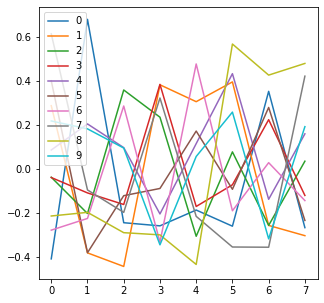

In [22]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

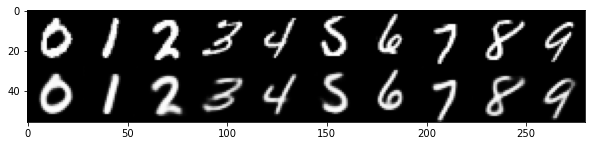

In [23]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [24]:
from XAE.sampler import gaus

exn = 5

In [25]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

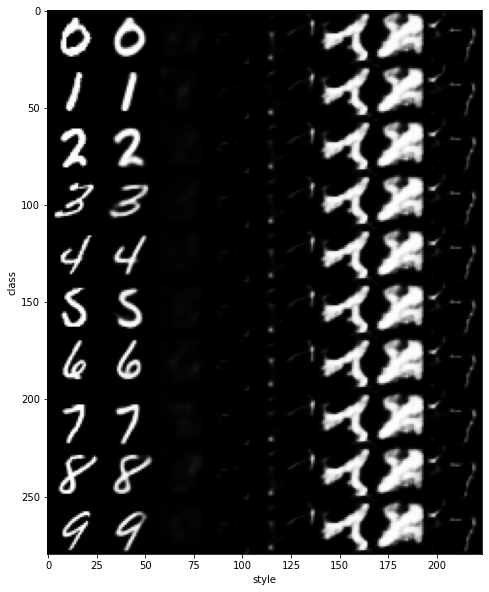

In [26]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [27]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

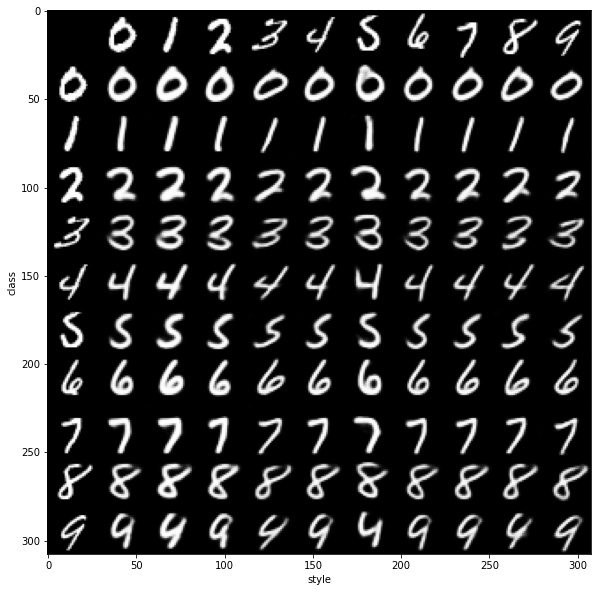

In [28]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()